# Categorization of Presidental Speech Topics using Latent Dirichlet Allocation

In [4]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
import json

# Set stop words
additional_stopWords = ['people', 'thank', 'you', 'applause','going', 'country', 'united', 'states'
                        've', 'one', 'must', 'know', 'us', 'let', 'said', 'america', 'american', 'americans',
                        'like', 'mr', '000', 'president', 'want', 'would', 'think', 'get', 'go', 'well', 'year',
                       'good', 'great', 'see', 'lot', 'many', 'time', '39', 'government', 'say',
                       'way', 'much', 'every', 'got', 'years', 'mdash', 'way', 'much', 'every', 'got', 'years',
                       'ever', 'really', 'done', 'even', 'also', 'states', 'state', 'upon', 'made', 'may']
#stopWords = set(stopwords.words('english'))
stopWords = nltk.corpus.stopwords.words('english')
stopWords.extend(additional_stopWords)

# https://www.projectpro.io/recipes/add-custom-stopwords-and-then-remove-them-from-text

In [156]:
# This preprocessing step just removes stopwords
def preprocessor(text):
    tokens = nltk.word_tokenize(text)
    return (" ").join([word for word in tokens if word not in stopWords])

class LDA_Presidential_Speeches:
    """Creates a class for Latent Dirichlet Allocation using Presidential Speeches
    Input:
        speeches = list of Presidential Speeches
        N_topics = number of topics for LDA to produce
        N_words = the number of words to show in a topic
        new_speech = narrative for a new accident report not in the training set
    Methods:
        Topics = Print the list of topics in the selected narratives
        Predict_Topics = Show the predicted probabilities for topics for a new accident narrative"""
    
    def __init__(self, speeches, N_topics=2, N_words = 10):
        # the speeches
        self.speeches = list(speeches['transcript'])
        
        # initialize variables
        self.N_topics = N_topics
        self.N_words = N_words
        
        # Get the word counts in the reports
        self.countVectorizer = CountVectorizer(stop_words=stopWords)
        self.termFrequency = self.countVectorizer.fit_transform(self.speeches)
        self.Words = self.countVectorizer.get_feature_names()
        
    def Topics(self):
        
        # Obtain the estimates for the LDA model
        self.lda = LatentDirichletAllocation(n_components=self.N_topics)
        self.lda.fit(self.termFrequency)
        
        
        # For each of the topics in the model add the top N_words the list of topics
        topics = list()
        for topic in self.lda.components_:
            topics.append([self.Words[i] for i in topic.argsort()[:-self.N_words - 1:-1]])
        
        
        # Create column names for the output matrix
        cols = list()
        for i in range(self.N_words):
            cols.append("Word "+(str(i+1)))
            
        # Create a dataframe with the topic no. and the words in each topic 
        # output this dataframe 
        Topics_df = pd.DataFrame(topics, columns = cols)
        Topics_df.index.name = "Topics"
        return Topics_df
    
    def Predict_Topics(self, new_speeches):
        
        # Get the list of new presidential speeches
        # and the number of new narratives
        self.new_speeches = list(new_speeches['transcript'])
        N_new_speeches = len(self.new_speeches)
        
        
        # For each of the new speeches 
        # obtain the estimated probabilities for each of the topics
        # in each of the new speeches as estimated by the LDA results
        # on the training set 
        new_speech_topics = list()
        for speech in self.new_speeches:
            #speech_new = preprocessor(speech)
            new_speech_topics.append(self.lda.transform(self.countVectorizer.transform([speech])))
            
        
        # Recast the list of probabilities for topics as an array 
        # of size no. of new reports X no. of topics
        new_speech_topics = np.array(new_speech_topics).reshape(N_new_speeches, self.N_topics)
        
        # Create column names for the output dataframe
        cols = list()
        for i in range(self.N_topics):
            cols.append("Topic "+(str(i+1)))        
        
        # Create the dataframe whose rows contain topic probabilities for 
        # specificed narratives/reports
        New_Speeches_df = pd.DataFrame(new_speech_topics, columns = cols ) 
        New_Speeches_df.insert(0, 'title', list(new_speeches['title']))
        New_Speeches_df.insert(0, 'date', list(new_speeches['date']))
        New_Speeches_df.insert(0, 'party', list(new_speeches['party']))
        New_Speeches_df.insert(0, 'president', list(new_speeches['president']))
        
        return New_Speeches_df

In [10]:
os.chdir('../data')

In [158]:
speeches = pd.read_json('mc_speeches.json')

def label_pres(president):
    
    rep = ['Abraham Lincoln', 'Benjamin Harrison','Calvin Coolidge','Chester A. Arthur',
           'Donald Trump','Dwight D. Eisenhower','George H. W. Bush', 'George W. Bush',
           'Gerald Ford','Herbert Hoover','James A. Garfield','Richard M. Nixon', 
           'Ronald Reagan','Rutherford B. Hayes', 'Theodore Roosevelt', 'Ulysses S. Grant',
           'Warren G. Harding','William McKinley', 'William Taft']
    dem = ['Andrew Jackson','Barack Obama',  'Bill Clinton','Franklin D. Roosevelt',
           'Franklin Pierce','Grover Cleveland','Harry S. Truman','James Buchanan',
           'James K. Polk', 'Jimmy Carter','Joe Biden', 'John F. Kennedy', 'Lyndon B. Johnson', 
           'Martin Van Buren','Woodrow Wilson']
    other = [ 'Andrew Johnson','George Washington','James Madison','James Monroe',
             'John Quincy Adams','John Adams',  'John Tyler','Millard Fillmore',
             'Thomas Jefferson', 'Zachary Taylor']
    
    if president in rep:
        return 'Republican'
    elif president in dem:
        return 'Democroat'
    else:
        return 'Other'
    
speeches['party'] = speeches['president'].apply(label_pres)

## Past 1920

In [28]:
speeches1 = speeches[speeches['date'] > '1920-01-01']
lda_speech2 = LDA_Presidential_Speeches(speeches = speeches1, N_topics = 15, N_words = 15)
lda_topics2 = lda_speech2.Topics()
lda_topics2

C:\Users\burke\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topics,,,,,,,,,,,,,,,
0,war,military,men,states,forces,world,fighting,attack,japanese,ships,made,air,germany,today,two
1,right,freedom,negro,states,men,howe,vote,alabama,cannot,rights,rome,law,free,world,color
2,states,upon,work,economic,public,world,business,may,national,banks,situation,cooperation,relief,industry,financial
3,tonight,law,rights,party,negro,man,violence,victims,day,right,vote,never,tell,scouts,love
4,election,grace,votes,border,day,states,immigration,ballots,pinckney,democrats,big,observers,counting,legal,happen
5,world,nation,war,men,freedom,peace,new,man,nations,life,today,upon,may,shall,human
6,iraq,iraqi,freedom,world,terrorists,nation,saddam,liberty,day,war,forces,terror,citizens,al,hussein
7,senator,believe,states,question,kennedy,administration,made,make,last,could,house,nixon,matter,first,secretary
8,new,work,make,help,tonight,children,congress,world,jobs,security,economy,nation,care,health,need


In [160]:
preds = lda_speech2.Predict_Topics(speeches1)
preds

,president,party,date,title,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
0,Lyndon B. Johnson,Democroat,1964-03-07,"March 7, 1964: Press Conference at the White H...",0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.432550,0.000035,0.433035,0.000035,0.133998,0.000035,0.000035,0.000035
1,Lyndon B. Johnson,Democroat,1964-04-16,"April 16, 1964: Press Conference at the State ...",0.049604,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.395049,0.000037,0.422247,0.000037,0.113570,0.019162,0.000037,0.000037
2,Lyndon B. Johnson,Democroat,1964-02-29,"February 29, 1964: Press Conference at the Sta...",0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.999719,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020
3,Lyndon B. Johnson,Democroat,1964-02-01,"February 1, 1964: Press Conference",0.053570,0.000041,0.137751,0.000041,0.000041,0.000041,0.000041,0.422175,0.000041,0.191847,0.000041,0.087960,0.037038,0.021867,0.047505
4,Lyndon B. Johnson,Democroat,1964-02-21,"February 21, 1964: Remarks at the Ninety Sixth...",0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.000136,0.998103,0.000136,0.000136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,Joe Biden,Democroat,2021-08-16,"August 16, 2021: Remarks on Situation in Afgha...",0.217869,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.638869,0.000065,0.000065,0.000065,0.000065,0.113548,0.029002
570,Joe Biden,Democroat,2021-08-26,"August 26, 2021: Statement on Terror Attacks i...",0.128924,0.000055,0.000055,0.000055,0.000055,0.000055,0.052118,0.181366,0.497249,0.000055,0.000055,0.139793,0.000055,0.000055,0.000055
571,Joe Biden,Democroat,2021-08-31,"August 31, 2021: Remarks on Ending the War in ...",0.039808,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.053237,0.803733,0.000047,0.000047,0.012105,0.000047,0.090645,0.000047
572,Joe Biden,Democroat,2021-09-09,"September 9, 2021: Remarks on Fighting the COV...",0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.617389,0.060617,0.000040,0.321517,0.000040,0.000040,0.000040


In [161]:
topics = ['WWII' , 'Civil Rights', 'US Economy', '3', 'Elections', 'US Freedoms', 'Terrorism', 'US Politics',
          'US Policy', 'US Economy', 'Social Policy', '11', 'World Peace', 'Vietnam', 'Soviet']
preds = preds.rename({'Topic 1':'WWII',
                                'Topic 2':'Civil Rights',
                                'Topic 3':'Economy',
                                'Topic 4':'Civil Rights',
                                'Topic 5':'Elections',
                                'Topic 6':'Freedoms',
                                'Topic 7':'Terrorism',
                                'Topic 8':'Politics',
                                'Topic 9':'Policy',
                                'Topic 10':'Economy',
                                'Topic 11':'Values',
                                'Topic 12':'Labor',           
                                'Topic 13':'World Peace',
                                'Topic 14':'Vietnam',
                                'Topic 15':'Soviet' }, axis=1)

preds['max_prob'] = preds.iloc[:,4:].idxmax(axis=1)

In [175]:
preds['decade'] = [int(str(i.year)[:-1]+'0') for i in preds['date']]
preds.to_csv(path_or_buf='preds.csv')

In [176]:
ct = pd.crosstab(preds.decade, preds.max_prob)
ct = ct.div(ct.sum(axis=1), axis=0)
ct
# ct.to_csv(path_or_buf='preds.csv')

max_prob,Civil Rights,Economy,Elections,Freedoms,Labor,Policy,Politics,Soviet,Terrorism,Values,Vietnam,WWII,World Peace
decade,,,,,,,,,,,,,
1920,0.000000,0.487179,0.000000,0.487179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641
1930,0.000000,0.800000,0.000000,0.175000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000
1940,0.000000,0.046512,0.000000,0.395349,0.023256,0.000000,0.046512,0.000000,0.000000,0.000000,0.093023,0.348837,0.046512
1950,0.000000,0.000000,0.000000,0.272727,0.090909,0.000000,0.090909,0.181818,0.000000,0.000000,0.000000,0.000000,0.363636
1960,0.066667,0.191667,0.000000,0.125000,0.008333,0.000000,0.158333,0.050000,0.016667,0.016667,0.058333,0.033333,0.275000
1970,0.019231,0.365385,0.000000,0.057692,0.076923,0.000000,0.019231,0.250000,0.000000,0.019231,0.115385,0.000000,0.076923
1980,0.014706,0.073529,0.000000,0.088235,0.205882,0.058824,0.014706,0.382353,0.014706,0.088235,0.000000,0.014706,0.044118
1990,0.018519,0.018519,0.000000,0.074074,0.148148,0.240741,0.018519,0.111111,0.018519,0.129630,0.092593,0.000000,0.129630
2000,0.000000,0.000000,0.000000,0.018868,0.094340,0.490566,0.000000,0.132075,0.207547,0.037736,0.000000,0.000000,0.018868


<AxesSubplot:xlabel='decade'>

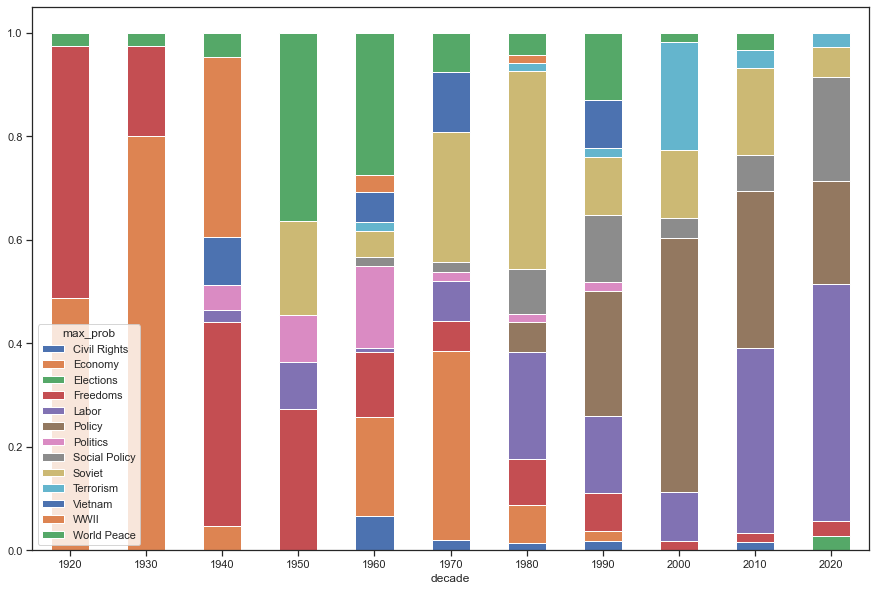

In [148]:
ct.plot(kind='bar', stacked=True, rot=0, figsize = (15,10))

<AxesSubplot:>

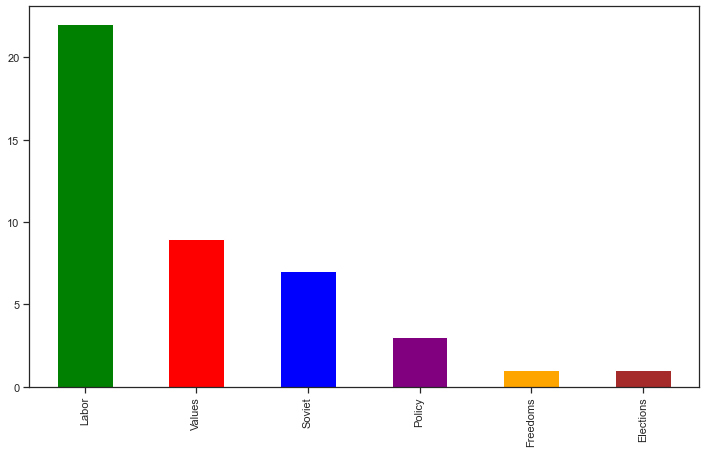

In [208]:
trump_preds = preds[preds['president'] == 'Donald Trump']
trump_counts = trump_preds.max_prob.value_counts()
trump_counts.plot.bar(color = ['green', 'red', 'blue', 'purple', 'orange', 'brown'], figsize=(12,7))

<AxesSubplot:>

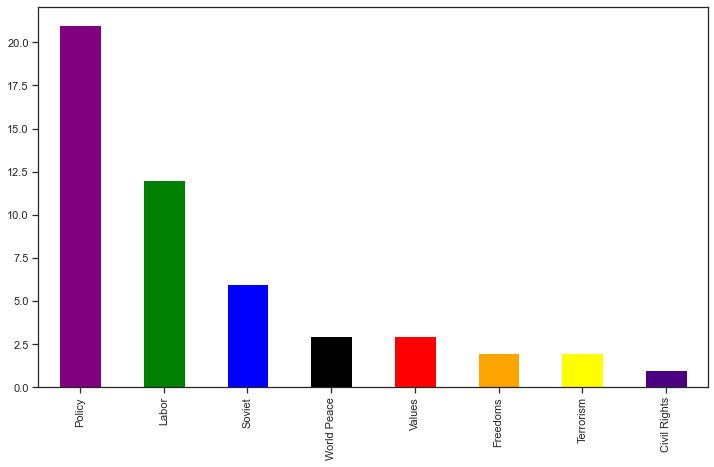

In [211]:
obama_preds = preds[preds['president'] == 'Barack Obama']
obama_counts = obama_preds.max_prob.value_counts().
obama_counts.plot.bar(color = ['purple', 'green', 'blue', 'black', 'red', 'orange', 'indigo', 'yellow'], figsize=(12,7))

<AxesSubplot:>

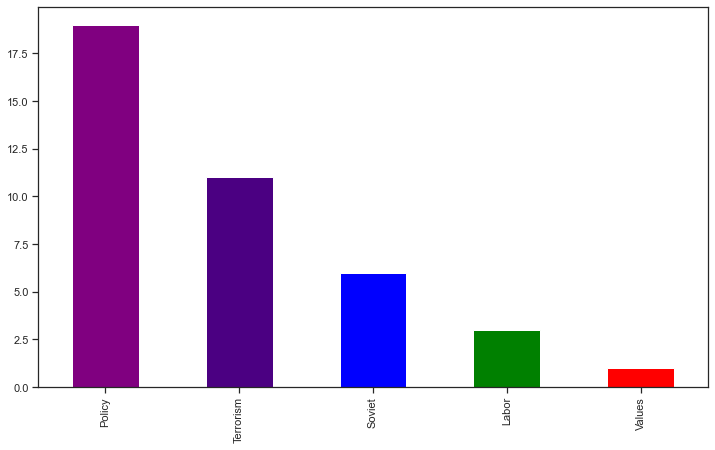

In [212]:
bush_preds = preds[preds['president'] == 'George W. Bush']
bush_counts = bush_preds.max_prob.value_counts()
bush_counts.plot.bar(color = ['purple', 'indigo', 'blue', 'green', 'red'], figsize=(12,7))

# Other Data Exploration

## Founding Fathers

In [151]:
founding_fathers = speeches[speeches['date'] < '1850-01-01']
lda_speech_ff = LDA_Presidential_Speeches(speeches = founding_fathers, N_topics = 3, N_words = 9)
lda_topics_ff = lda_speech_ff.Topics()
lda_topics_ff

C:\Users\burke\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topics,,,,,,,,,
0,public,power,constitution,congress,shall,bank,without,general,laws
1,line,shall,river,st,british,treaty,boundary,day,nation
2,congress,war,public,mexico,last,treaty,citizens,peace,part


In [127]:
speeches[speeches['date'] < '1850-01-01']

,title,date,url,president,transcript,party
390,"April 30, 1789: First Inaugural Address",1789-04-30,/the-presidency/presidential-speeches/april-30...,George Washington,Fellow Citizens of the Senate and the House of...,Other
391,"October 3, 1789: Thanksgiving Proclamation",1789-10-03,/the-presidency/presidential-speeches/october-...,George Washington,Whereas it is the duty of all Nations to ackno...,Other
392,"January 8, 1790: First Annual Message to Congress",1790-01-08,/the-presidency/presidential-speeches/january-...,George Washington,Fellow Citizens of the Senate and House of Rep...,Other
393,"December 8, 1790: Second Annual Message to Con...",1790-12-08,/the-presidency/presidential-speeches/december...,George Washington,Fellow citizens of the Senate and House of Re...,Other
394,"December 29, 1790: Talk to the Chiefs and Coun...",1790-12-29,/the-presidency/presidential-speeches/december...,George Washington,"I the President of the United States, by my o...",Other
...,...,...,...,...,...,...
699,"August 14, 1848: Message Regarding Slavery in ...",1848-08-14,/the-presidency/presidential-speeches/august-1...,James K. Polk,To the House of Representatives of the United ...,Democroat
700,"December 5, 1848: Fourth Annual Message to Con...",1848-12-05,/the-presidency/presidential-speeches/december...,James K. Polk,Fellow-Citizens of the Senate and of the House...,Democroat
701,"January 2, 1849: Message Regarding War-time Me...",1849-01-02,/the-presidency/presidential-speeches/january-...,James K. Polk,To the House of Representatives of the United ...,Democroat
702,"February 8, 1849: Message Regarding the Treaty...",1849-02-08,/the-presidency/presidential-speeches/february...,James K. Polk,To the House of Representatives of the United ...,Democroat


## New Age (1960 - Present)

In [98]:
new_age = speeches[speeches['date'] > '1960-01-01']

In [105]:
lda_speech = LDA_Presidential_Speeches(speeches = new_age, N_topics = 5, N_words = 10)
lda_speech.Topics()

C:\Users\burke\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topics,,,,,,,,,,
0,peace,world,war,vietnam,nations,would,new,south,nation,soviet
1,world,peace,nation,freedom,new,nations,war,today,time,country
2,president,would,think,government,tax,time,country,going,congress,year
3,new,americans,years,work,make,every,year,jobs,congress,time
4,president,going,want,think,get,great,country,say,lot,would


In [65]:
preds = lda_speech.Predict_Topics(new_age)
preds

,president,party,date,title,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,Lyndon B. Johnson,Democroat,1964-03-07,"March 7, 1964: Press Conference at the White H...",0.000046,0.000046,0.329380,0.277936,0.000046,0.000046,0.000046,0.000046,0.000046,0.392361
1,Lyndon B. Johnson,Democroat,1964-04-16,"April 16, 1964: Press Conference at the State ...",0.000049,0.000049,0.081918,0.204101,0.000049,0.000049,0.027912,0.000049,0.000049,0.685775
2,Lyndon B. Johnson,Democroat,1964-02-29,"February 29, 1964: Press Conference at the Sta...",0.000027,0.000027,0.000027,0.537929,0.000027,0.000027,0.000027,0.172194,0.000027,0.289688
3,Lyndon B. Johnson,Democroat,1964-02-01,"February 1, 1964: Press Conference",0.000056,0.000056,0.117002,0.275769,0.000056,0.000056,0.000056,0.000056,0.000056,0.606835
4,Lyndon B. Johnson,Democroat,1964-02-21,"February 21, 1964: Remarks at the Ninety Sixth...",0.321086,0.000193,0.000193,0.056284,0.000193,0.489056,0.132415,0.000193,0.000193,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,Joe Biden,Democroat,2021-08-16,"August 16, 2021: Remarks on Situation in Afgha...",0.000090,0.169996,0.000090,0.044024,0.000090,0.645797,0.000090,0.090670,0.000090,0.049064
437,Joe Biden,Democroat,2021-08-26,"August 26, 2021: Statement on Terror Attacks i...",0.000071,0.226897,0.000071,0.145689,0.000071,0.213482,0.000071,0.325249,0.015979,0.072418
438,Joe Biden,Democroat,2021-08-31,"August 31, 2021: Remarks on Ending the War in ...",0.000065,0.235794,0.000065,0.000065,0.000065,0.550589,0.000065,0.165230,0.020975,0.027085
439,Joe Biden,Democroat,2021-09-09,"September 9, 2021: Remarks on Fighting the COV...",0.000055,0.000055,0.402219,0.000055,0.000055,0.000055,0.000055,0.597340,0.000055,0.000055


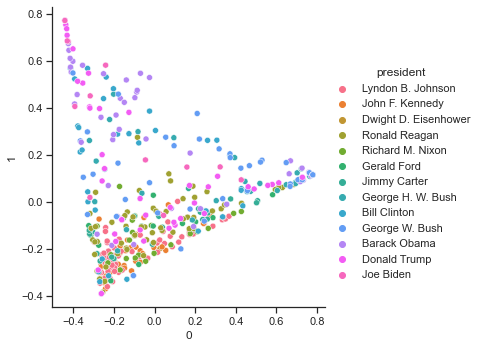

In [66]:
pca = PCA(n_components=2)
pca = pd.DataFrame(pca.fit_transform(preds.iloc[:,4:]))
pca['president'] = new_age['president'].reset_index(drop=True)
seaborn.relplot(data=pca, x=0, y=1, hue='president')
plt.show()

### State of the Union - New Age

In [101]:
state_of_the_unions = new_age[new_age['title'].str.contains('Union')]

In [ ]:
lda_speech = LDA_Presidential_Speeches(speeches = state_of_the_unions, N_topics = 8, N_words = 20)
lda_speech.Topics()

In [102]:
preds = lda_speech.Predict_Topics(state_of_the_unions)
preds

,president,party,date,title,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,Lyndon B. Johnson,Democroat,1964-01-08,"January 8, 1964: State of the Union",0.481978,0.000079,0.000079,0.184430,0.000079,0.000079,0.000079,0.333195
1,John F. Kennedy,Democroat,1963-01-14,"January 14, 1963: State of the Union Address",0.215934,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.783792
2,John F. Kennedy,Democroat,1962-01-11,"January 11, 1962: State of the Union Address",0.284558,0.000037,0.000037,0.003774,0.000037,0.000037,0.000037,0.711482
3,John F. Kennedy,Democroat,1961-01-30,"January 30, 1961: State of the Union",0.210644,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.789079
4,Lyndon B. Johnson,Democroat,1965-01-04,"January 4, 1965: State of the Union",0.227921,0.000061,0.000061,0.517871,0.000061,0.000061,0.000061,0.253905
5,Lyndon B. Johnson,Democroat,1966-01-12,"January 12, 1966: State of the Union",0.269870,0.000048,0.000048,0.653924,0.000048,0.000048,0.000048,0.075967
6,Lyndon B. Johnson,Democroat,1967-01-10,"January 10, 1967: State of the Union Address",0.352754,0.000018,0.000018,0.514617,0.000018,0.000018,0.000018,0.132537
7,Lyndon B. Johnson,Democroat,1968-01-17,"January 17, 1968: State of the Union Address",0.645067,0.000026,0.000026,0.233005,0.000026,0.000026,0.000026,0.121797
8,Lyndon B. Johnson,Democroat,1969-01-14,"January 14, 1969: State of the Union Address",0.603844,0.000034,0.000034,0.301961,0.000034,0.043712,0.000034,0.050348
9,Richard M. Nixon,Republican,1970-01-22,"January 22, 1970: State of the Union Address",0.467776,0.000061,0.000061,0.193187,0.000061,0.000061,0.000061,0.338731


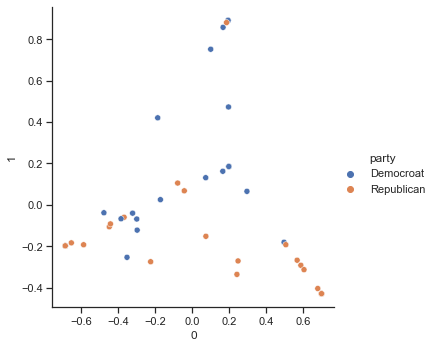

In [69]:
pca = PCA(n_components=2)
pca = pd.DataFrame(pca.fit_transform(preds.iloc[:,4:]))
pca['party'] = state_of_the_unions['party'].reset_index(drop=True)
seaborn.relplot(data=pca, x=0, y=1, hue='party')
plt.show()

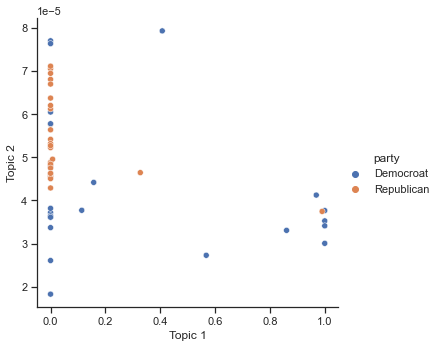

In [70]:
seaborn.relplot(data=preds, x='Topic 1', y='Topic 2', hue='party')
plt.show()

## Twenty First Centrury

In [90]:
twenty_first_centurty = speeches[speeches['date'] > '2000-01-01']
twenty_first_centurty = twenty_first_centurty[twenty_first_centurty['president'] != 'Bill Clinton']

In [91]:
lda_speech = LDA_Presidential_Speeches(speeches = twenty_first_centurty, N_topics = 8, N_words = 10)
lda_speech.Topics()

C:\Users\burke\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topics,,,,,,,,,,
0,world,nation,iraq,security,war,nations,freedom,peace,new,country
1,jobs,new,make,work,years,americans,economy,time,year,get
2,president,going,want,think,get,well,would,go,lot,time
3,justice,court,laughter,judge,law,barrett,much,life,supreme,assad
4,election,black,years,today,lot,want,votes,going,many,see
5,going,president,want,great,country,think,get,right,would,good
6,oil,gulf,drilling,coast,hiv,aids,spill,clean,bp,region
7,relief,tax,baghdadi,achievement,pipes,killed,died,nervous,night,leader


In [ ]:
preds = lda_speech.Predict_Topics(twenty_first_centurty)
preds

,president,party,date,title,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,George W. Bush,Republican,2001-01-20,"January 20, 2001: First Inaugural Address",0.000171,0.000171,0.293270,0.705705,0.000171,0.000171,0.000171,0.000171
1,George W. Bush,Republican,2001-06-07,"June 7, 2001: Remarks on Signing the Economic ...",0.000254,0.192441,0.088621,0.000255,0.472718,0.245202,0.000254,0.000254
2,George W. Bush,Republican,2002-01-29,"January 29, 2002: State of the Union Address",0.000064,0.000064,0.000064,0.934235,0.065382,0.000064,0.000064,0.000064
3,George W. Bush,Republican,2003-01-28,"January 28, 2003: State of the Union Address",0.000046,0.000046,0.000046,0.149620,0.000046,0.850107,0.000046,0.000046
4,George W. Bush,Republican,2004-01-20,"January 20, 2004: State of the Union Address",0.000047,0.000047,0.000047,0.194100,0.000047,0.805621,0.000047,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...
140,Joe Biden,Democroat,2021-08-16,"August 16, 2021: Remarks on Situation in Afgha...",0.000112,0.057233,0.000112,0.000112,0.000112,0.942094,0.000112,0.000112
141,Joe Biden,Democroat,2021-08-26,"August 26, 2021: Statement on Terror Attacks i...",0.000089,0.500513,0.000089,0.203843,0.000089,0.295196,0.000089,0.000089
142,Joe Biden,Democroat,2021-08-31,"August 31, 2021: Remarks on Ending the War in ...",0.000082,0.080246,0.000082,0.000082,0.000082,0.919264,0.000082,0.000082
143,Joe Biden,Democroat,2021-09-09,"September 9, 2021: Remarks on Fighting the COV...",0.381580,0.000069,0.618005,0.000069,0.000069,0.000069,0.000069,0.000069


C:\Users\burke\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\burke\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 145 samples in 0.001s...
[t-SNE] Computed neighbors for 145 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 145 / 145
[t-SNE] Mean sigma: 0.338941
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.817860
[t-SNE] KL divergence after 750 iterations: 0.212706


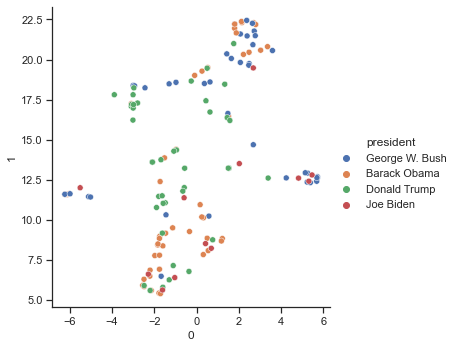

In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne = pd.DataFrame(tsne_model.fit_transform(preds.iloc[:,4:]))
tsne['president'] = twenty_first_centurty['president'].reset_index(drop=True)
seaborn.relplot(data=tsne, x=0, y=1, hue='president')
plt.show()

### Twenty First Century - War

In [86]:
war_words = ['Afghan', 'Pakistan', 'Iraq', 'Osama', 'War', 'Qasem']
covid_words = ['COVID']
twenty_first_centurty_war = twenty_first_centurty[twenty_first_centurty['title'].str.contains('|'.join(war_words))]

In [ ]:
war_words

['Afghan', 'Pakistan', 'Iraq', 'Osama', 'War', 'Qasem']

In [76]:
lda_speech = LDA_Presidential_Speeches(speeches = twenty_first_centurty_war, N_topics = 2, N_words = 30)
lda_speech.Topics()

C:\Users\burke\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,...,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30
Topics,,,,,,,,,,,,,,,,,,,,,
0,iraq,iraqi,war,iraqis,troops,forces,terrorists,military,security,would,...,nation,many,government,baghdad,violence,regime,nations,every,work,east
1,afghanistan,president,war,country,military,taliban,afghan,world,would,going,...,get,well,nation,never,made,americans,great,last,make,national


In [77]:
preds = lda_speech.Predict_Topics(twenty_first_centurty_war)
preds

,president,party,date,title,Topic 1,Topic 2
0,George W. Bush,Republican,2008-03-19,"March 19, 2008: Remarks on the War on Terror",0.999518,0.000482
1,Barack Obama,Democroat,2009-12-01,"December 1, 2009: Speech on Strategy in Afghan...",0.000513,0.999487
2,Barack Obama,Democroat,2010-08-31,"August 31, 2010: Address on the End of the Com...",0.727886,0.272114
3,Barack Obama,Democroat,2011-05-01,"May 1, 2011: Remarks on the Death of Osama Bin...",0.001122,0.998878
4,Barack Obama,Democroat,2011-06-22,"June 22, 2011: Remarks on the Afghanistan Pullout",0.001181,0.998819
5,Barack Obama,Democroat,2011-10-21,"October 21, 2011: Remarks on the End of the Wa...",0.349397,0.650603
6,George W. Bush,Republican,2004-07-17,"July 17, 2004: Remarks on National Security an...",0.000827,0.999173
7,George W. Bush,Republican,2003-03-17,"March 17, 2003: Address to the Nation on Iraq",0.999096,0.000904
8,George W. Bush,Republican,2003-03-20,"March 20, 2003: Address on the Start of the Ir...",0.996929,0.003071
9,George W. Bush,Republican,2003-11-06,"November 6, 2003: Remarks on Freedom in Iraq a...",0.001233,0.998767
